# Regression

In [19]:
# add parent directory to system path (can be excluded when package structure better)
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [23]:
from helper import get_sinusoid_example
import matplotlib.pyplot as plt 

# jax
import jax
from jax import random, tree_util, value_and_grad, numpy as jnp
from jaxtyping import PyTree

# laplacestuff
from functools import partial
from laplax.curv.full import to_dense, hvp, flatten_hessian, cov_scale_full_hessian, flatten_hessian_pytree
from laplax.eval.push_forward import create_mc_predictions_for_data_point_fn
from laplax.eval.metrics import estimate_q
from laplax.eval.utils import evaluate_metrics_on_dataset

# flax for training, optax for optimization
import optax
import jax
import jax.numpy as jnp
import optax
from flax import nnx
from jax import random, value_and_grad
import math
import equinox as eqx

In [52]:
# generate training data
import tensorflow_datasets as tfds  # TFDS to download MNIST.
import tensorflow as tf  # TensorFlow / `tf.data` operations.

tf.random.set_seed(0)  # Set the random seed for reproducibility.

train_steps = 1200
eval_every = 200
batch_size = 32

train_ds: tf.data.Dataset = tfds.load('mnist', split='train')
test_ds: tf.data.Dataset = tfds.load('mnist', split='test')

train_ds = train_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
)  # normalize train set
test_ds = test_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
)  # Normalize the test set.

# Create a shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from.
train_ds = train_ds.repeat().shuffle(1024)
# Group into batches of `batch_size` and skip incomplete batches, prefetch the next sample to improve latency.
train_ds = train_ds.take(train_steps).batch(batch_size, drop_remainder=True).prefetch(1)
# Group into batches of `batch_size` and skip incomplete batches, prefetch the next sample to improve latency.
test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

In [53]:
from flax import nnx  # The Flax NNX API.
from functools import partial

class CNN(nnx.Module):
  """A simple CNN model."""

  def __init__(self, rngs: nnx.Rngs):
    self.conv1 = nnx.Conv(1, 32, kernel_size=(3, 3), rngs=rngs)
    self.conv2 = nnx.Conv(32, 64, kernel_size=(3, 3), rngs=rngs)
    self.avg_pool = partial(nnx.avg_pool, window_shape=(2, 2), strides=(2, 2))
    self.linear1 = nnx.Linear(3136, 256, rngs=rngs)
    self.linear2 = nnx.Linear(256, 10, rngs=rngs)

  def __call__(self, x):
    x = self.avg_pool(nnx.relu(self.conv1(x)))
    x = self.avg_pool(nnx.relu(self.conv2(x)))
    x = x.reshape(x.shape[0], -1)  # flatten
    x = nnx.relu(self.linear1(x))
    x = self.linear2(x)
    return x

def create_model(rngs):
    model = CNN(rngs)
    return model

# Mean squared error loss function
def loss_fn(model: CNN, batch):
  logits = model(batch['image'])
  loss = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=batch['label']
  ).mean()
  return loss, logits


@nnx.jit
def update(model: CNN, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.
    optimizer.update(grads)

@nnx.jit
def eval_step(model: CNN, metrics: nnx.MultiMetric, batch):
  loss, logits = loss_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])


metrics_history = {
  'train_loss': [],
  'train_accuracy': [],
  'test_loss': [],
  'test_accuracy': [],
}

# Training loop
# Assuming `train_loader` is a generator that yields (X, y) batches
def train_model(n_epochs, rng_key):
    model = create_model(rng_key)
    optimizer = nnx.Optimizer(model, optax.adamw(1e-2))
    metrics = nnx.MultiMetric(accuracy=nnx.metrics.Accuracy(), loss=nnx.metrics.Average('loss'),)
    for step, batch in enumerate(train_ds.as_numpy_iterator()):
        update(model, optimizer, metrics, batch)
        if step > 0 and (step % eval_every == 0 or step == train_steps - 1):  # One training epoch has passed.
            # Log the training metrics.
            for metric, value in metrics.compute().items():  # Compute the metrics.
              metrics_history[f'train_{metric}'].append(value)  # Record the metrics.
            metrics.reset()  # Reset the metrics for the test set.
        
            # Compute the metrics on the test set after each training epoch.
            for test_batch in test_ds.as_numpy_iterator():
              eval_step(model, metrics, test_batch)
        
            # Log the test metrics.
            for metric, value in metrics.compute().items():
              metrics_history[f'test_{metric}'].append(value)
            metrics.reset()  # Reset the metrics for the next training epoch.

            print(
      f"[train] step: {step}, "
      f"loss: {metrics_history['train_loss'][-1]}, "
      f"accuracy: {metrics_history['train_accuracy'][-1] * 100}"
)
            print(
              f"[test] step: {step}, "
              f"loss: {metrics_history['test_loss'][-1]}, "
              f"accuracy: {metrics_history['test_accuracy'][-1] * 100}"
            )
            return model

    

In [54]:
n_epochs = 10
model = train_model(n_epochs, nnx.Rngs(0))

2024-11-06 09:58:49.206816: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


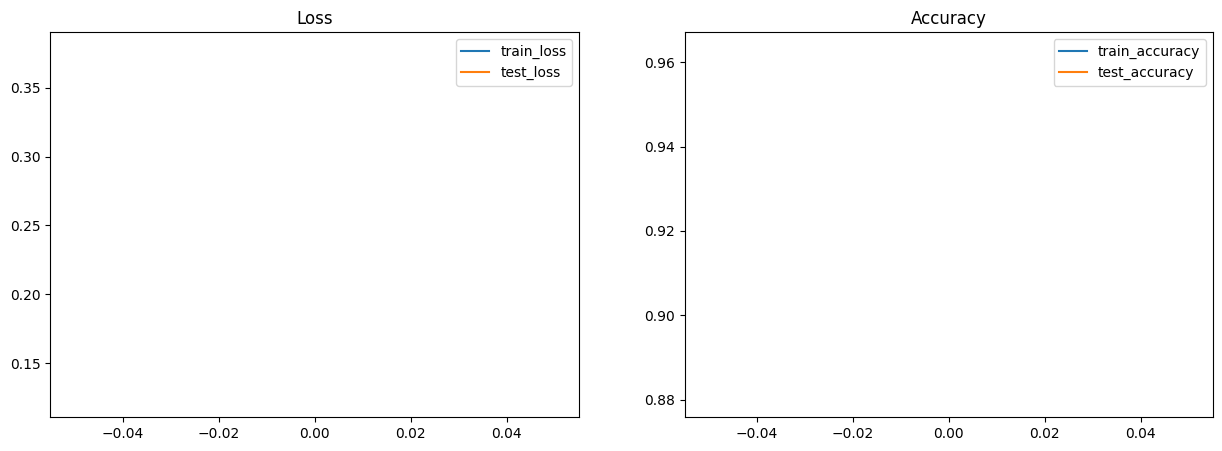

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train', 'test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()

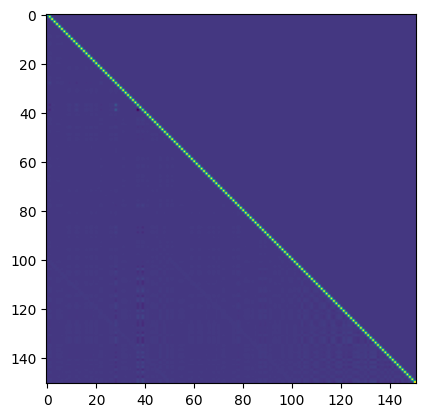

In [32]:
loss_fn = lambda y_pred, y_true: jnp.mean((y_pred - y_true) ** 2) # noqa: E731

filtered_model = eqx.filter(model, eqx.is_inexact_array)
def model_fn(params, x):
    new_model = eqx.tree_at(lambda m: m, filtered_model, params)
    return jax.vmap(new_model)(x)

final_params = eqx.filter(model, eqx.is_inexact_array)
                          
full_fn = lambda p, data: loss_fn(model_fn(p, data[0]), data[1])
flat_params = jax.tree.flatten(final_params)[0]
num_params = sum(math.prod(param.shape) for param in flat_params)
hessian_vector_product = lambda v: hvp(full_fn, final_params, (X_train, y_train), v)
hessian = to_dense(hessian_vector_product, num_params)
hessian = jax.tree_util.tree_map(lambda x: x.T, hessian)

flat_hessian = flatten_hessian_pytree(hessian, final_params)
flat_hessian = (flat_hessian + flat_hessian.T) / 2


cov_scale = cov_scale_full_hessian(flat_hessian, 2, 100*jnp.eye(flat_hessian.shape[0]))
plt.imshow(cov_scale)

In [33]:
flat_params, def_params = jax.tree_util.tree_flatten(final_params)
mean = jnp.concatenate([p.flatten() for p in flat_params])
params_shape = jnp.cumsum(jnp.asarray([jnp.prod(jnp.asarray(p.shape)) for p in flat_params]))
def create_param_builder(final_params: PyTree) -> callable:

    """Create PyTree Reconstruction."""
    flat_params, def_params = tree_util.tree_flatten(final_params)
    params_shape = [p.shape for p in flat_params]
    params_index = jnp.cumsum(jnp.asarray([jnp.prod(jnp.asarray(p.shape)) for p in flat_params]))[:-1]
    return lambda x: tree_util.tree_unflatten(def_params, [p.reshape(pshape) for p, pshape in zip(jnp.split(x, params_index), params_shape)])


param_builder = create_param_builder(final_params)

In [34]:
rng_key = random.key(711)
samples = random.multivariate_normal(
    rng_key, mean, cov_scale, shape=(1000,)
)

In [35]:
def model_fn(params, x):
    new_model = eqx.tree_at(lambda m: m, filtered_model, params)
    return new_model(x)
    
ptw_pred_fn = create_mc_predictions_for_data_point_fn(
    model_fn, mean, cov_scale, param_builder
)

metrics = evaluate_metrics_on_dataset(
    ptw_pred_fn, (X_test, jnp.sin(X_test)), metrics = [estimate_q]
)

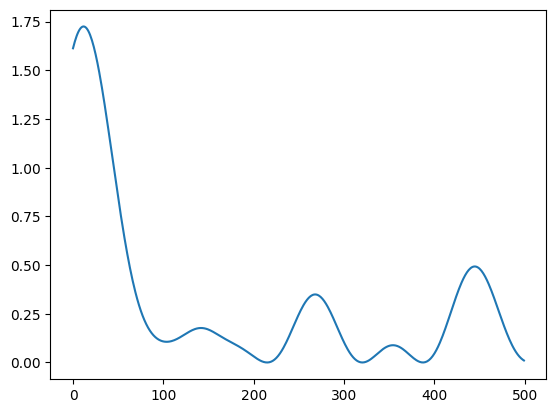

In [36]:
plt.plot(metrics['estimate_q'])